<a href="https://colab.research.google.com/github/LuciusMelillo09/DataScience/blob/main/Unit6/Luci_MeliUnit6Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import graphviz as gv
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install bambi
import arviz as az
import matplotlib.pyplot as plt
import bambi as bmb

In [ ]:
!pip install bambi

In [ ]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

#Introduction

In this project, I will attempt to predict the Weight for different fish species, by using their physical measurements, such as Length, measured in 3 different ways (Vertical, Fork Length, and Total), Width, and Height.

In [ ]:
data = 'https://raw.githubusercontent.com/LuciusMelillo09/DataScience/main/Unit6/goog4_request%26X-Goog-Date%3D20260130T194902Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4c36c553d7223629a7c207f31415cbdda57f2e26b110ad6b0f0eaa6d0e3ee512419598000f763f968a7b261bd26e676e502e5e89342f029cf5f33ae51918f56da9c5.csv'
data2 = pd.read_csv(data)
data2

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


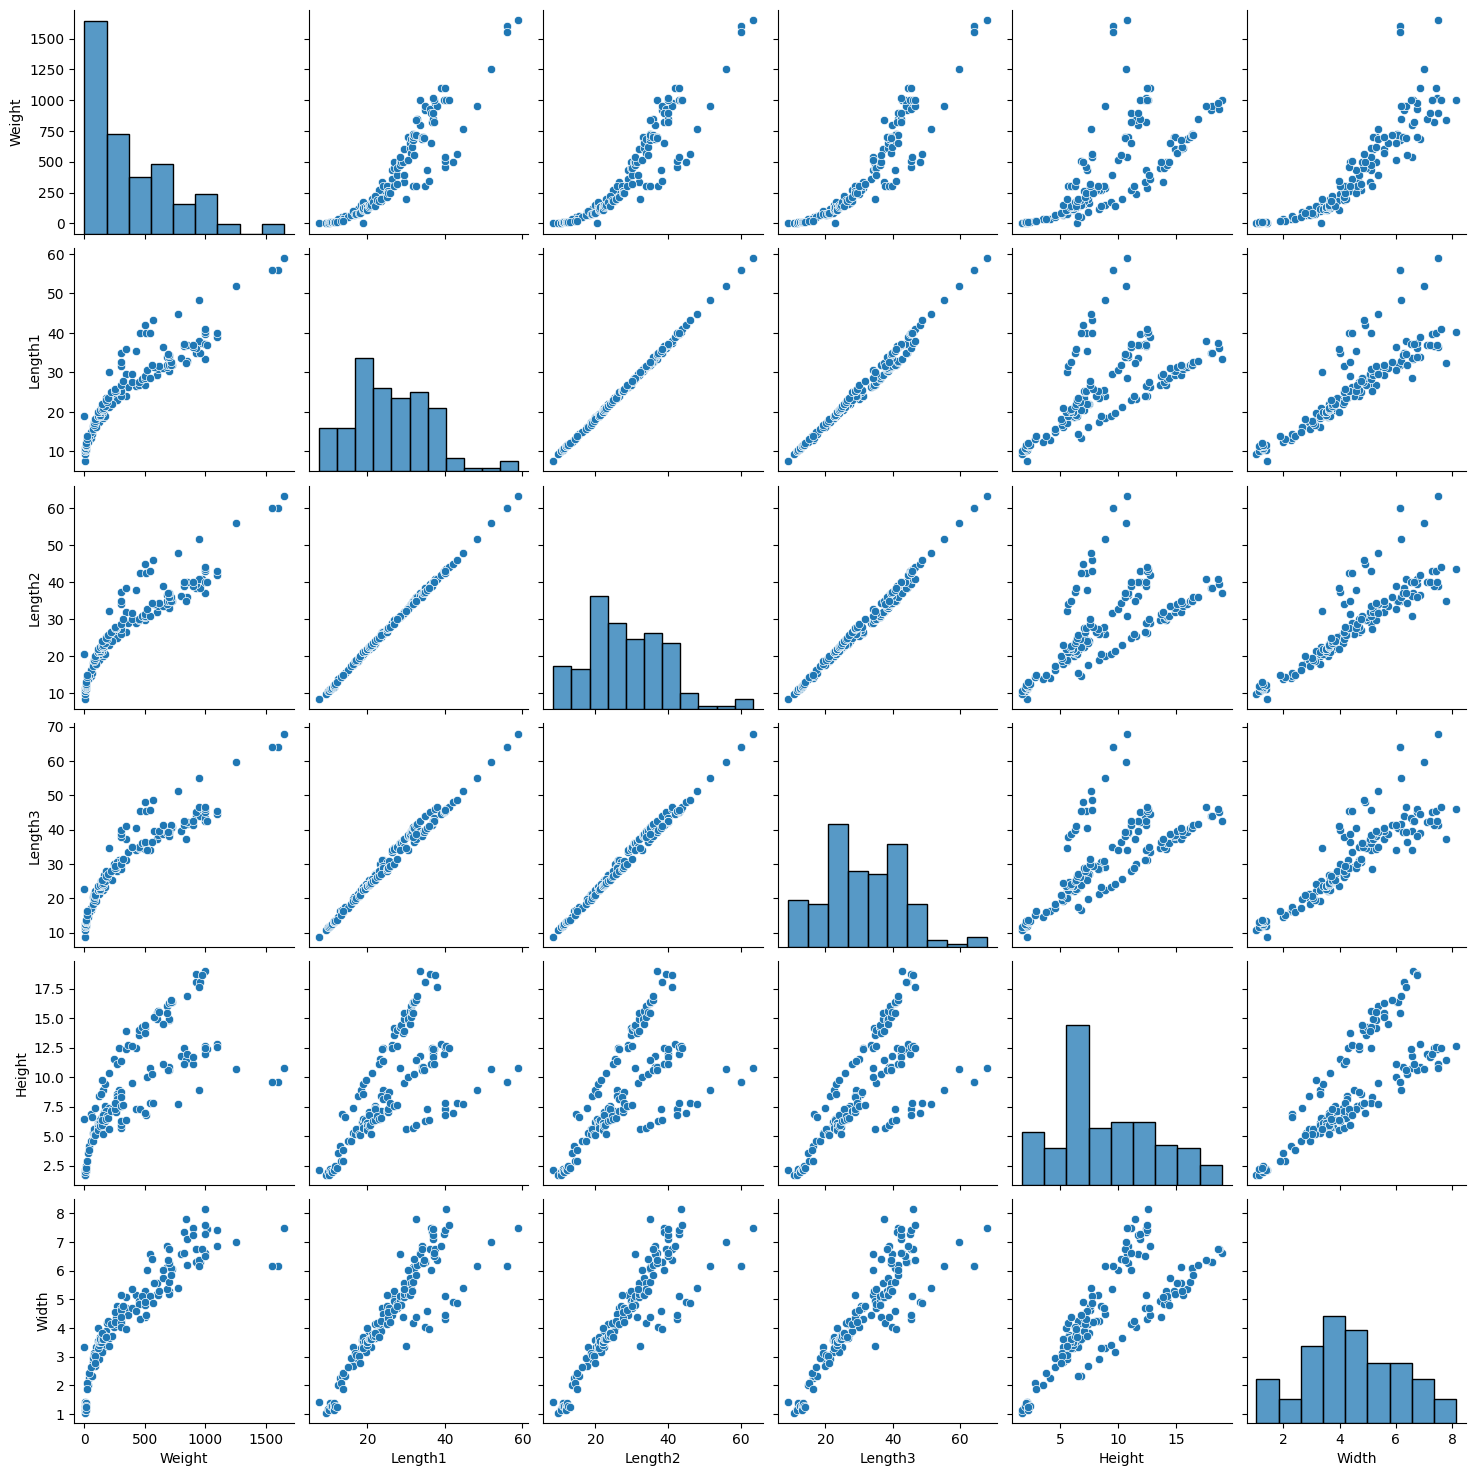

In [ ]:
sns.pairplot(data2)


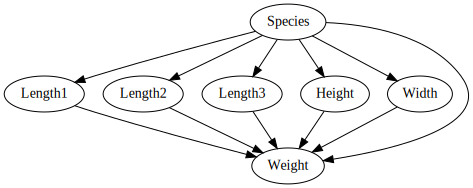

In [ ]:
dag_b = gv.Digraph(comment='fish')

dag_b.node('L', 'Length1')
dag_b.node('M','Length2')
dag_b.node('N', 'Length3')
dag_b.node('H','Height')
dag_b.node('X','Width')
dag_b.node('W','Weight')
dag_b.node('S','Species')





dag_b.edges(['LW', 'MW', 'NW', 'HW', 'XW', 'SW', 'SL', 'SH', 'SM', 'SN', 'SX'])

dag_b

Gemini used code below to help me use Gamma, wasn't working before.


In [ ]:
data2_filtered = data2[data2['Weight'] > 0].copy()

First, I created a model that tried to predict the Weight of the Fish using all of the variables I thought may be correlated (no visualization).

In [ ]:
model = bmb.Model("Weight ~ Length1 + Length2 + Length3 + Width + Species", data=data2_filtered)
idata = model.fit(idata_kwargs={'log_likelihood': True})

Then, I created a model that predicts the Weight of the fish using Length1 and Species as independent variables, using a simple linear model.

In [ ]:
model2 = bmb.Model("Weight ~ Length1 + Species", data=data2_filtered)
idata2 = model2.fit(idata_kwargs={'log_likelihood': True})

(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Length1', ylabel='Weight'>], dtype=object))

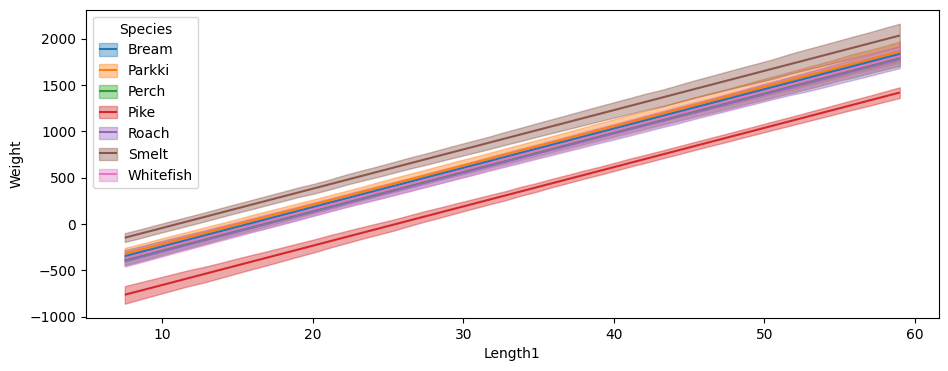

In [ ]:
bmb.interpret.plot_predictions(model2, idata2, ["Length1", "Species"], fig_kwargs={"figsize":(11, 4)})

I noticed that there were negative values for weight, which should never happen. Therefore, I decided to switch from the Linear model to a Gamma distribution, so

So first, I remade my reference model, using all of the variables I thought would affect weight, but this time using a Gammas distribution

In [ ]:
model3 = bmb.Model("Weight ~ Length1 + Length2 + Length3 + Width + Species", data=data2_filtered, family='gamma', link='log')
idata3 = model3.fit(idata_kwargs={'log_likelihood': True})

Now, I decided to test how important the species was in predicting the weight, as I thought this would probably be a very important factor, so I made the same model as the reference, just excluding species.

In [ ]:
model0 = bmb.Model("Weight ~ Length1 + Length2 + Length3 + Width", data=data2_filtered, family='gamma', link='log')
idata0 = model0.fit(idata_kwargs={'log_likelihood': True})

In [ ]:
model_dict = {
    "Linear_All_Predictors": idata,
    "Gamma_All_Predictors": idata3,
    "Gamma_All_Predictors_NoSpecies": idata0,

}
cmp_df_bmb = az.compare(model_dict)
cmp_df_bmb


/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Gamma_All_Predictors,0,-834.468471,15.555471,0.000000,0.953213,27.807657,0.000000,True,log
Gamma_All_Predictors_NoSpecies,1,-913.146559,6.137842,78.678088,0.020836,13.688040,22.725982,False,log
Linear_All_Predictors,2,-950.380960,14.920062,115.912489,0.025951,14.962109,20.318216,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

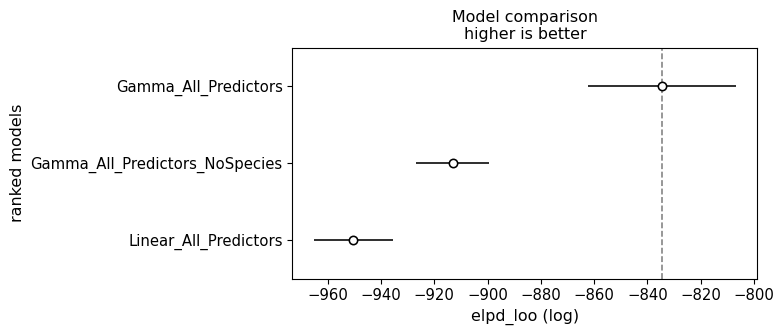

In [ ]:
az.plot_compare(cmp_df_bmb)

So I confirmed my hypotheses that Gamma was a better model to use, and species is a very important factor

This model predicts the Weight of the fish using Length1 and Species as predictors, but I decided to use a Gamma distribution for the likelihood and a log link function. I did this because this is better for a positive, continuous, and skewed dependent variable like Weight.

In [ ]:
model4 = bmb.Model("Weight ~ Length1 + Species", data=data2_filtered, family='gamma', link='log')
idata4 = model4.fit(idata_kwargs={'log_likelihood': True})

(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Length1', ylabel='Weight'>], dtype=object))

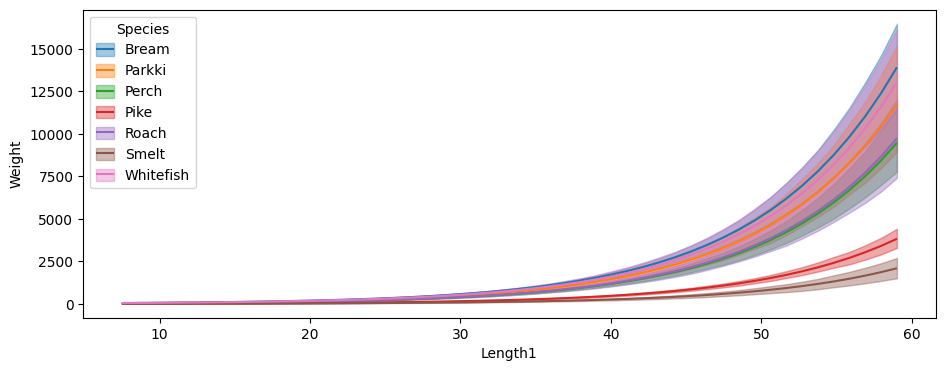

In [ ]:
bmb.interpret.plot_predictions(model4, idata4, ["Length1","Species"], fig_kwargs={"figsize":(11, 4)}, sample_new_groups=True)

In [ ]:
model5 = bmb.Model("Weight ~ Width + Species", data=data2_filtered, family='gamma', link='log')
idata5 = model5.fit(idata_kwargs={'log_likelihood': True})

(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Width', ylabel='Weight'>], dtype=object))

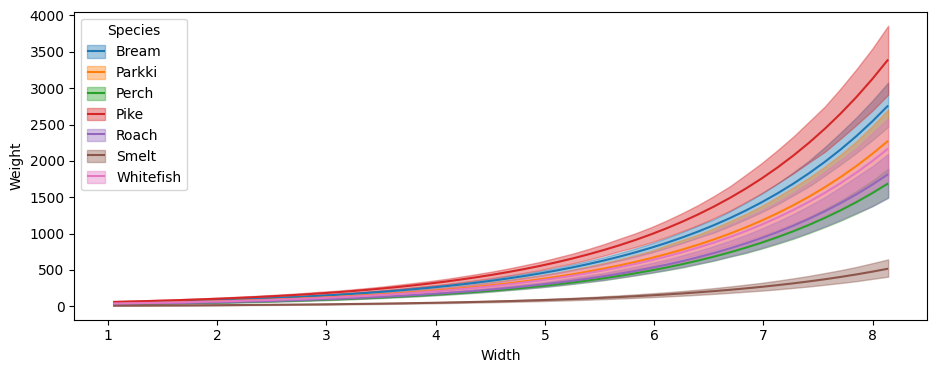

In [ ]:
bmb.interpret.plot_predictions(model5, idata5, ["Width","Species"], fig_kwargs={"figsize":(11, 4)}, sample_new_groups=True)

In [ ]:
model6 = bmb.Model("Weight ~ Height + Species", data=data2_filtered, family='gamma', link='log')
idata6 = model6.fit(idata_kwargs={'log_likelihood': True})

(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Height', ylabel='Weight'>], dtype=object))

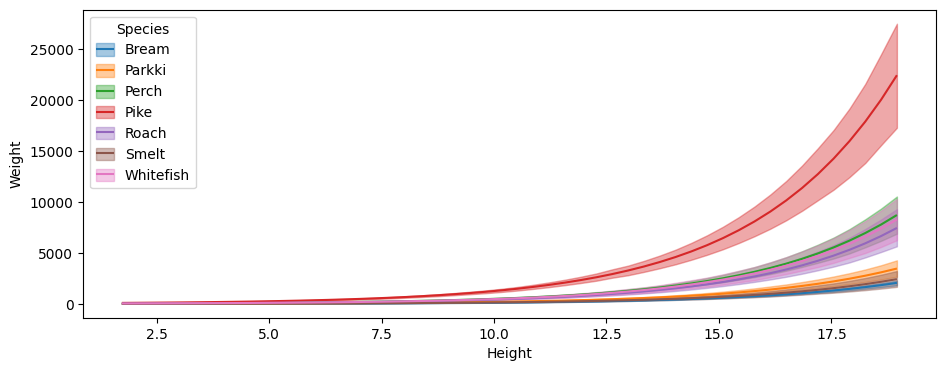

In [ ]:
bmb.interpret.plot_predictions(model6, idata6, ["Height","Species"], fig_kwargs={"figsize":(11, 4)}, sample_new_groups=True)

In [ ]:
model7 = bmb.Model("Weight ~ Length2 + Species", data=data2_filtered, family='gamma', link='log')
idata7 = model7.fit(idata_kwargs={'log_likelihood': True})

(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Length2', ylabel='Weight'>], dtype=object))

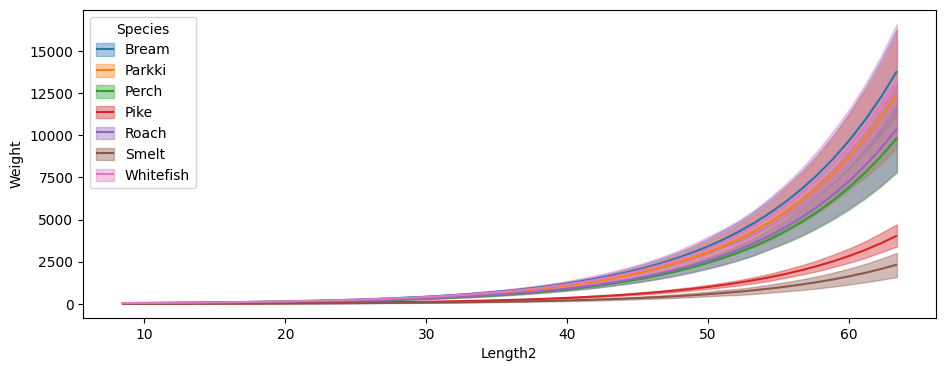

In [ ]:
bmb.interpret.plot_predictions(model7, idata7, ["Length2","Species"], fig_kwargs={"figsize":(11, 4)}, sample_new_groups=True)

In [ ]:
model8 = bmb.Model("Weight ~ Length3 + Species", data=data2_filtered, family='gamma', link='log')
idata8 = model8.fit(idata_kwargs={'log_likelihood': True})

(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Length3', ylabel='Weight'>], dtype=object))

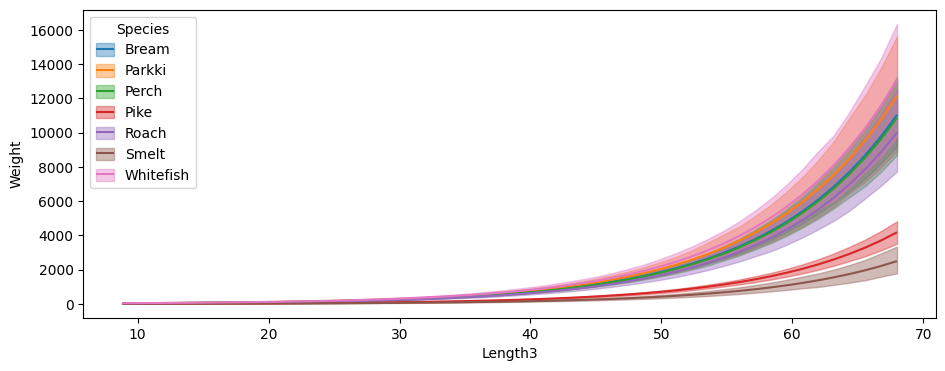

In [ ]:
bmb.interpret.plot_predictions(model8, idata8, ["Length3","Species"], fig_kwargs={"figsize":(11, 4)}, sample_new_groups=True)

In [ ]:
model9 = bmb.Model("Weight ~ Length3 + Length1 + Species", data=data2_filtered, family='gamma', link='log')
idata9 = model9.fit(idata_kwargs={'log_likelihood': True})

(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Length3', ylabel='Weight'>], dtype=object))

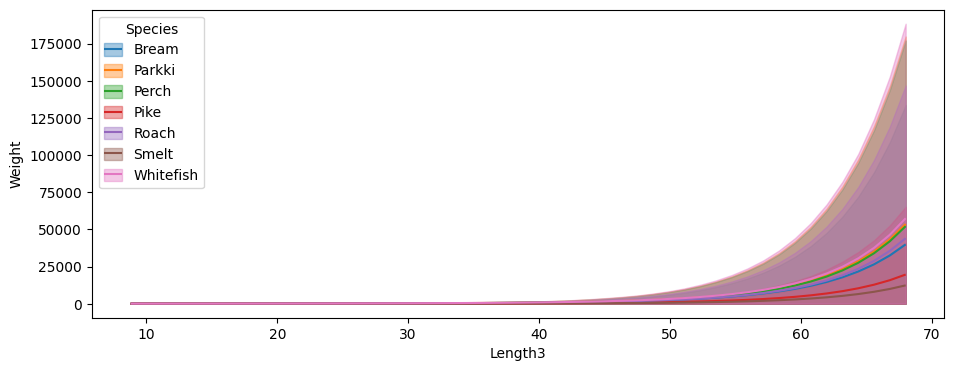

In [ ]:
bmb.interpret.plot_predictions(model9, idata9, ["Length3","Species"], fig_kwargs={"figsize":(11, 4)}, sample_new_groups=True)

#Comparison


In [ ]:
model_dict = {
    "Linear_All_Predictors": idata,
    "Linear_Length1_Species": idata2,
    "Gamma_All_Predictors": idata3,
    "Gamma_All_Predictors_NoSpecies": idata0,
    "Gamma_Length1_Species": idata4,
    "Gamma_Width_Species": idata5,
    "Gamma_Height_Species": idata6,
    "Gamma_Length2_Species": idata7,
    "Gamma_Length3_Species": idata8,
    "Gamma_Length3_Length1_Species": idata9
}
cmp_df_bmb = az.compare(model_dict)
cmp_df_bmb


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

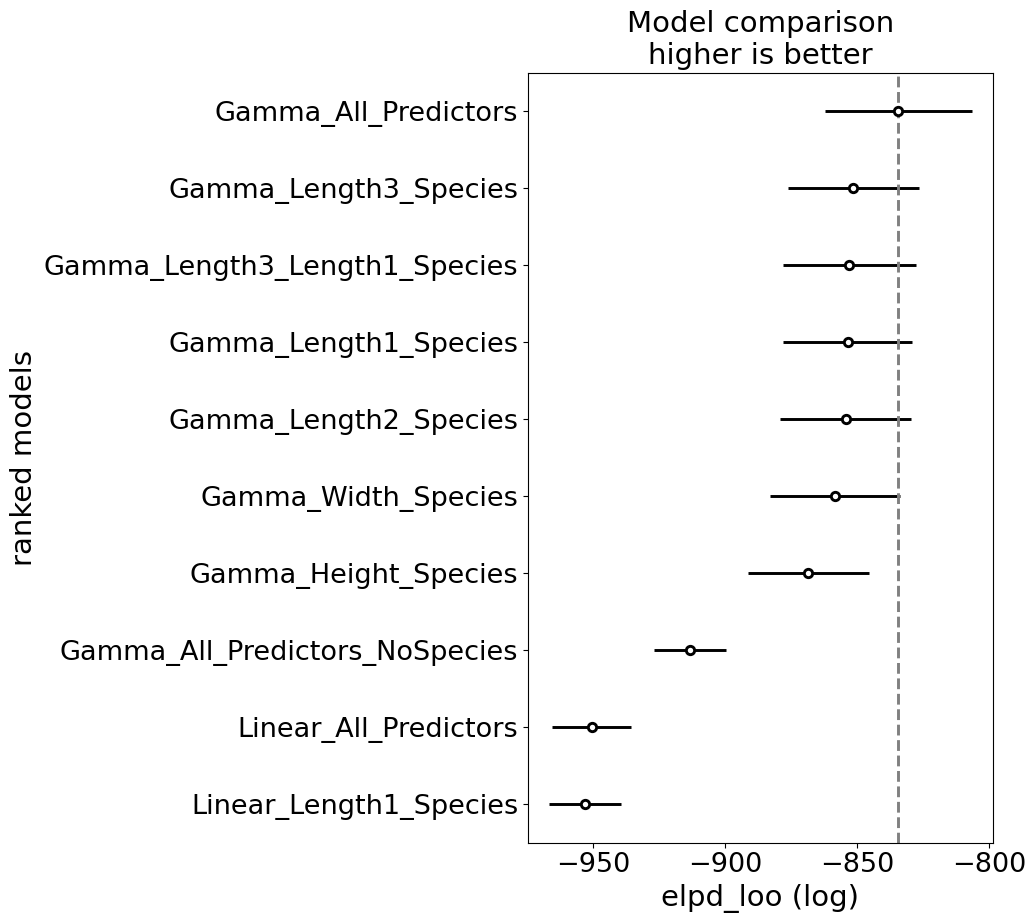

In [ ]:
az.plot_compare(cmp_df_bmb)

#Conclusion

My reference model still fits the best, using all the variables with a Gamma distribution, but I figured out that the most important factors were species, followed by Length3, the maximum length from snout to tip of tail, followed by the fish's vertical length, length from the snout to the base of the tail.
